# Self-Driving Car Engineer Nanodegree
## Deep Learning
## Project: Build a Traffic Sign Recognition Classifier

## Step 0: Load The Data

In [1]:
# Utility packages
import numpy as np

# Printing helper packages
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Load pickled data
import pickle

# Load training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### test set to ensure every thing is valid
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))

### Data Set Summary

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0), return_counts=True)[0])

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

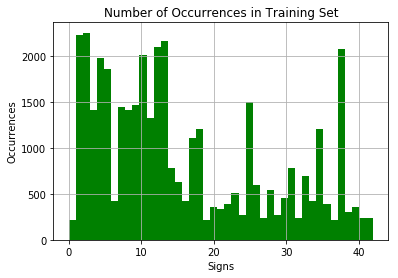

In [3]:
#The work on this cell is based on this
#https://github.com/deacons2016/traffic_signs/blob/master/Traffic_Sign_Classifier.ipynb
def load_label_file(file):
    lines = open(file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_file("signnames.csv")

# the histogram of the training data
n, bins, patches = plt.hist(y_train, n_classes, facecolor='green')

plt.xlabel('Signs')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences in Training Set')
plt.grid(True)

plt.show()

Road narrows on the right 24


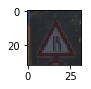

In [4]:
#Show random sample of training set
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(label_descriptions.get(y_train[index]),y_train[index])


## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

I did four things for data preprocessing:
- Convert RGB to YUV and use Y channel only.
- Normalize Y channel
- Create augmented images based on translating image and rotating it.
- Write Python generator function that create 5 new images for each patch and apply the steps mentioned above.


Data preprocessing step is inpired by this work:
http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf

#### This will increase batch size from 128 to (5 * 128) + 128 = 768




In [5]:
### shuffle data
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [6]:
### add helper functions to randomly translate and rotate images
import cv2

def translateImage(image):
    t_x = (np.random.randn(1)*.5)[0]
    t_y = (np.random.randn(1)*.5)[0]
    #print(t_x,t_y)
    rows,cols,_ = image.shape
    M = np.float32([[1,0,t_x],[0,1,t_y]])
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst

def rotateImage(image):
    theta = (np.random.randn(1)*5)[0]
    #print(theta)
    rows,cols,_ = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    dst = cv2.warpAffine(image,M,(cols,rows))
    return dst


In [7]:
### add helper function to create 5 new augmented images for each image

def generateAugmentedImages(X_data,y_data):
    num_images = 5 * len(X_data)
    x_aug = np.zeros(shape=(num_images,32,32,3)).astype(np.uint8)
    y_aug = np.zeros(shape=(num_images))
    aug_idx = 0
    for idx, img in enumerate(X_data):
        lbl = y_data[idx]
        for itr in range(5):
            new_image = translateImage(rotateImage(img))
            x_aug[aug_idx] = new_image
            y_aug[aug_idx] = lbl
            aug_idx = aug_idx + 1
    X_data = np.concatenate((X_data, x_aug), axis=0)
    y_data = np.concatenate((y_data, y_aug), axis=0)
    
    return X_data, y_data
    

#x,y = generateAugmentedImages(X_train[0:128],y_train[0:128])

#print(len(x),len(y))

In [8]:
### convert to YUV, extract Y and normalize it

def imagestoY(batch_x):
    for x in batch_x:
        img_out = cv2.cvtColor(x, cv2.COLOR_RGB2YUV)
        img_out = img_out[:,:,0].reshape(32,32,1)
        img_out = img_out - np.mean(img_out)
        yield img_out

In [9]:
### Python generator function that applied to fetch batches and do data preprocessing        
# https://github.com/justheuristic/prefetch_generator
def iterate_minibatches(num_examples, batch_size, X_data, y_data, is_training = 1):
    for offset in range(0, num_examples, batch_size):
        end = offset + batch_size
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        if is_training == 1:
            batch_x, batch_y = generateAugmentedImages(batch_x, batch_y)
            batch_x, batch_y = shuffle(batch_x, batch_y)
        batch_x = imagestoY(batch_x)
        yield batch_x,batch_y



### Split Data into Training, Validation and Testing Sets

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation =   train_test_split(X_train, y_train, test_size=.2, random_state=0)

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_validation)

print("Number of training examples before augmentaion = {0} and after augmentation = {1}".format(n_train, n_train*6) )
print("Number of validation examples =", n_validation)


Number of training examples before augmentaion = 31367 and after augmentation = 188202
Number of validation examples = 7842


### Model Architecture

Model Arch is the same as LeNet but changed the depth of CONV layers to be 12 instead of 6 for the first CONV layer and 48 instead of 12 for the second one.

I also added a fully connected layer with 1200-400 followed by 400-120, 120-84, and 84-43

Finally, I added a dropout layer for each FC layer with keep prop of 80%

In [11]:
import tensorflow as tf

EPOCHS = 10
BATCH_SIZE = 128

In [12]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x12.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 12), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(12))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x12. Output = 14x14x12.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x48.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 48), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(48))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x48. Output = 5x5x48.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x48. Output = 1200.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1200. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1200, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Regularization.
    fc1    = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(120))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Regularization.
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    
    # Regularization.
    fc3    = tf.nn.dropout(fc3, keep_prob)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Features and Labels

In [13]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Training Pipeline

In [14]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Train, Validate and Test the Model
### Model Evaluation

In [17]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

from prefetch_generator import BackgroundGenerator
from confusionmatrix import ConfusionMatrix

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    confusion_valid = ConfusionMatrix(n_classes)
    sess = tf.get_default_session()
    for b_x,b_y in BackgroundGenerator(iterate_minibatches(num_examples,BATCH_SIZE, X_data, y_data,0)):
        batch_x = np.array([x for x in b_x]) #np.fromiter(b_x,float)
        batch_y = np.array([y for y in b_y]) #np.fromiter(b_y,float)
        res = sess.run(logits, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        preds = np.argmax(res, 1)
        confusion_valid.batch_add(batch_y, preds)
    return confusion_valid #.accuracy()
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        #total_accuracy += (accuracy * len(batch_x))
    #return total_accuracy / num_examples
    #for offset in range(0, num_examples, BATCH_SIZE):
        #batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        #total_accuracy += (accuracy * len(batch_x))
    #return total_accuracy / num_examples

### Train the Model

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for b_x,b_y in BackgroundGenerator(iterate_minibatches(num_examples,BATCH_SIZE, X_train, y_train)):
            batch_x = np.array([x for x in b_x]) #np.fromiter(b_x,float)
            batch_y = np.array([y for y in b_y]) #np.fromiter(b_y,float)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: .8})
        #for offset in range(0, num_examples, BATCH_SIZE):
            #end = offset + BATCH_SIZE
            #batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy.accuracy()))
        print()
        
    saver.save(sess, 'lenetTS')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.725

EPOCH 2 ...
Validation Accuracy = 0.945

EPOCH 3 ...
Validation Accuracy = 0.969

EPOCH 4 ...
Validation Accuracy = 0.978

EPOCH 5 ...
Validation Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.992

EPOCH 9 ...
Validation Accuracy = 0.994

EPOCH 10 ...
Validation Accuracy = 0.994

Model saved


### Evaluate the Model

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy.accuracy()))

Test Accuracy = 0.954


In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

def display_images(images, cmap=None, num_rows=3):
    """
        Displays an image array a grid with number of rows=num_rows
    """
    num_images = len(images)
    num_cols = int(num_images/num_rows)
    fig, axes = plt.subplots(num_rows, num_cols)
    
    for i, ax in enumerate(axes.flat):
        # Only plot the valid images
        if i < num_images:
            img = images[i]

            # Plot image.
            if(cmap):
                ax.imshow(img, cmap=cmap)
            else:
                ax.imshow(img)

def read_images(fileNames, display=True):
    images = []
    for file in fileNames:
        image = cv2.imread(file)
        image = image.astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return images    
        
    

test_files = [file for file in glob.glob("gtsrb/*")]


images = read_images(test_files)
display_images(images, num_rows=4)

x_collected = images
y_collected_true = np.array([26, 11, 40, 12, 18, 11, 23, 14])
y_collected_true_one_hot = encode_labels(y_collected_true)

NameError: name 'glob' is not defined